# Model Selection
Model selection Model selection is a critical step in the modeling procedure where you compare, evaluate, and choose the best predictive model from a set of candidates. The goal of model selection is to identify the model that will perform best on future data, not just the training set. The process typically involves:
- Comparing different algorithms (e.g., linear regression, decision trees, random forests, etc.).
- Tuning model hyperparameters to optimize performance.
- Using statistical criteria (such as AIC, BIC, or adjusted R²) and/or validation metrics (such as accuracy, RMSE, ROC-AUC) to assess model quality.
- Employing cross-validation or holdout validation to estimate how well each model generalizes to new, unseen data.
- Selecting the model that best balances predictive accuracy, interpretability, and complexity for your specific problem.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

## Load Data

In [2]:
input_folder = "../.local/analysis_pipeline/data_exploration"
model_data = pd.read_parquet(f"{input_folder}/model_data.parquet")

## Build Model

In [3]:
# Define the list of predictors
pred_lst = ['agecat2', 'gender', 'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value']
# Split the data into training and validation sets
train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(45300, 24)
(15092, 24)

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,...,annual_premium,agecat2,pol_year,pol_quarter,veh_cnt,claim_sev,claim_sev_capped,claim_amt_capped,fold,sample
0,64080188,2017-07-10,M,2.0,1989-01-04,631.0,B,140.9,4,TRUCK,...,716.53,5.0,2017,3,1,NaN,NaN,0.000000,3,1|bld
2,82742606,2017-02-01,M,6.0,1942-07-25,838.0,D,88.8,3,SEDAN,...,716.53,1.0,2017,1,1,159.375757,159.375757,159.375757,1,1|bld
3,43601997,2017-10-17,M,5.0,1959-06-08,835.0,E,NaN,2,SEDAN,...,716.53,2.0,2017,4,1,NaN,NaN,0.000000,3,1|bld
4,58746861,2017-04-13,F,4.0,1967-05-16,748.0,C,123.0,3,HBACK,...,716.53,3.0,2017,2,1,143.555642,143.555642,143.555642,3,1|bld
6,92111059,2017-11-29,M,3.0,1976-10-31,759.0,E,75.0,4,STNWG,...,716.53,4.0,2017,4,1,NaN,NaN,0.000000,1,1|bld


In [4]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support
import xgboost as xgb

# Define features and target
y = train_data['claim_amt_capped']
X = train_data[pred_lst].copy()

# Convert object columns to pandas Categorical dtype for XGBoost native categorical support
for col in ['gender', 'area', 'veh_body']:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# XGBoost DMatrix for all training data with categorical support
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',         # Tweedie regression objective
    'tweedie_variance_power': 1.5,      # Tweedie power (1=Poisson, 2=Gamma, 1<p<2 for insurance)
    'learning_rate': 0.05,              # Step size shrinkage (smaller = more robust, slower learning)
    'max_depth': 4,                     # Maximum tree depth (controls model complexity)
    'min_child_weight': 100,            # Minimum sum of instance weight (hessian) needed in a child (min samples per leaf, set for 45,300 samples)
    'subsample': 0.8,                   # Fraction of samples used per tree (prevents overfitting)
    'colsample_bytree': 0.8,            # Fraction of features used per tree (prevents overfitting)
    'lambda': 1.0,                      # L2 regularization term (prevents overfitting)
    'alpha': 0.0,                       # L1 regularization term (prevents overfitting)
    'nthread': -1,                      # Use all CPU cores
    'seed': 42                          # Random seed for reproducibility
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,  # 5-fold cross-validation
    metrics='rmse',  # or another appropriate metric
    early_stopping_rounds=30,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_num_boost_round
 )

# --- Hyper-parameter definitions ---
# objective:      Loss function to optimize (here, Tweedie regression for insurance data)
# tweedie_variance_power: Tweedie power parameter (1=Poisson, 2=Gamma, 1<p<2 for insurance)
# learning_rate:  Step size shrinkage to prevent overfitting (lower = slower, more robust)
# max_depth:      Maximum depth of each tree (higher = more complex, risk of overfitting)
# min_child_weight: Minimum sum of instance weight (hessian) needed in a child (higher = more conservative, prevents overfitting, set to 100 for 45,300 samples)
# subsample:      Fraction of samples used per tree (lower = more regularization)
# colsample_bytree: Fraction of features used per tree (lower = more regularization)
# lambda:         L2 regularization term on weights (higher = more regularization)
# alpha:          L1 regularization term on weights (higher = more regularization)
# nthread:        Number of parallel threads (set to -1 to use all cores)
# seed:           Random seed for reproducibility
# early_stopping_rounds: Stop training if validation metric does not improve for this many rounds

[0]	train-rmse:3314.96002+44.38601	test-rmse:3311.03859+172.07629
[50]	train-rmse:2822.35755+29.34812	test-rmse:2869.58320+144.40096
[50]	train-rmse:2822.35755+29.34812	test-rmse:2869.58320+144.40096
[100]	train-rmse:2510.43536+25.17595	test-rmse:2648.70152+123.77413
[100]	train-rmse:2510.43536+25.17595	test-rmse:2648.70152+123.77413
[150]	train-rmse:2417.66439+21.29564	test-rmse:2622.34868+131.57636
[150]	train-rmse:2417.66439+21.29564	test-rmse:2622.34868+131.57636
[175]	train-rmse:2388.99340+19.39637	test-rmse:2625.40212+133.39118
[175]	train-rmse:2388.99340+19.39637	test-rmse:2625.40212+133.39118
Best num_boost_round from CV: 147
Best num_boost_round from CV: 147


In [5]:
# --- Model Fitting Score and Prediction ---
# Prepare train and validation data for prediction
X_train = train_data[pred_lst].copy()
X_val = val_data[pred_lst].copy()

# Convert object columns to category for both sets
for col in ['gender', 'area', 'veh_body']:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
    if X_val[col].dtype == 'object':
        X_val[col] = X_val[col].astype('category')

# DMatrix for prediction
dtrain_pred = xgb.DMatrix(X_train, enable_categorical=True)
dval_pred = xgb.DMatrix(X_val, enable_categorical=True)

# In-sample fitted values
train_pred = model.predict(dtrain_pred)
train_data['xgb_tweedie_pred'] = train_pred

# Out-of-sample prediction on validation set
val_pred = model.predict(dval_pred)
val_data['xgb_tweedie_pred'] = val_pred


C:\Users\mengjin6\AppData\Local\Temp\ipykernel_4300\344244991.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['xgb_tweedie_pred'] = train_pred
C:\Users\mengjin6\AppData\Local\Temp\ipykernel_4300\344244991.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['xgb_tweedie_pred'] = val_pred


## Model Evaluation
Below please find resources on different model evaluation metrics:
1. Gini coefficient: The Gini coefficient is a statistical measure of inequality, but in the context of the Casualty Actuarial Society (CAS), it is used to evaluate the effectiveness of predictive models, such as those used for insurance ratemaking. In this application, a Gini index measures how well a model's predictions (like for pure premium or risk scores) distinguish between high-risk and low-risk policyholders, with a higher Gini coefficient indicating better model performance. (Source: Search "Gini coefficient Casualty Actuarial Society").
2. https://www.casact.org/sites/default/files/presentation/rpm_2019_presentations_m-4_williams.pdf

### On training data

Top Lift: 7.6513
R^2: 0.4557
RMSE: 2450.30
MAE: 679.45


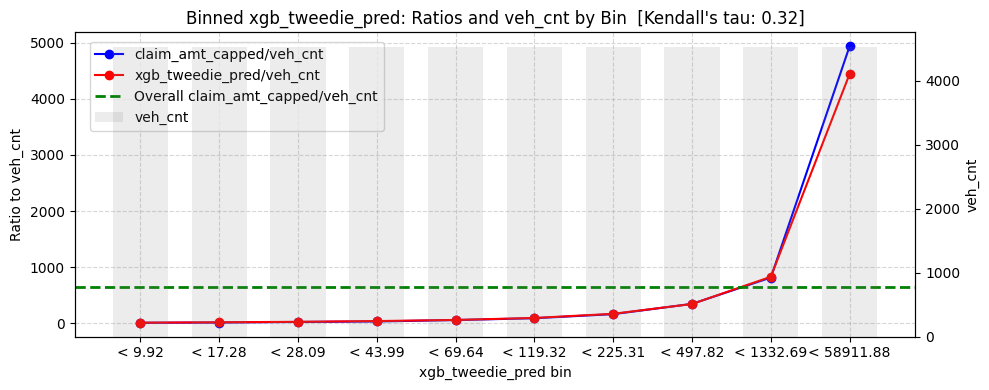

In [ ]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck

# Select validation sample for predictiveness check
data = train_data

# Define variables
exp_var = 'veh_cnt'
pred_var = 'xgb_tweedie_pred'
var_1 = 'claim_amt_capped'
var_2 = 'xgb_tweedie_pred'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

pc.top_lift()
print(f"Top Lift: {pc.top_lift:.4f}")
# Compute R^2, RMSE, and MAE
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
r2_train = r2_score(data[var_1], data[var_2])
rmse_train = root_mean_squared_error(data[var_1], data[var_2])
mae_train = mean_absolute_error(data[var_1], data[var_2])
print(f"R^2: {r2_train:.4f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")

pc.plot(figsize=(10, 4))



In [7]:

# Compute R^2, RMSE, and MAE
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
r2_train = r2_score(data[var_1], data[var_2])
rmse_train = root_mean_squared_error(data[var_1], data[var_2])
mae_train = mean_absolute_error(data[var_1], data[var_2])
print(f"R^2: {r2_train:.4f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")

R^2: 0.4557
RMSE: 2450.30
MAE: 679.45


In [8]:
pc.top_lift()

TypeError: 'numpy.float64' object is not callable